In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from Session import SessionLite, build_flu_array_single, Session
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os, pickle, copy
from sklearn.decomposition import PCA
import warnings
import pandas as pd
import math, cmath
from tqdm import tqdm
import pop_off_functions as pof
import pop_off_plotting as pop
from IPython.core.debugger import Pdb
ipdb = Pdb()
import ptitprince as pt
import copy
from datetime import datetime
import scipy.stats

## Load data in form of Jimmy's PAS object
warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon=True)
lm = pas.linear_models[0]
pas.sessions

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape
long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


{0: instance Mouse J064, run 10 of Session class,
 1: instance Mouse J064, run 11 of Session class,
 2: instance Mouse J064, run 14 of Session class,
 3: instance Mouse RL070, run 28 of Session class,
 4: instance Mouse RL070, run 29 of Session class,
 5: instance Mouse RL117, run 26 of Session class,
 6: instance Mouse RL117, run 29 of Session class,
 7: instance Mouse RL117, run 30 of Session class,
 8: instance Mouse RL123, run 22 of Session class,
 9: instance Mouse RL116, run 32 of Session class,
 10: instance Mouse RL116, run 33 of Session class}

In [3]:
## Create sessions object from PAS:

try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
print(int_keys_pas_sessions)
i_s = 0
for ses in pas.sessions.values():  # load into sessions dict (in case pas skips an int as key)
    ses.signature = f'{ses.mouse}_R{ses.run_number}'
    sessions[i_s] = ses
    i_s += 1
#     if ses.signature != 'RL117_R29':  # one that used not to have spont data
#         sessions[i_s] = ses
#         i_s += 1
#     else:
#         f'{ses.signature} has been excluded !!! (because no spont data available)'
print(sessions)
assert len(sessions) == 11
pof.label_urh_arm(sessions=sessions)  # label arm and urh

# for kk, ss in sessions.items():
    
    
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')
tp_dict = pof.create_tp_dict(sessions=sessions)


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5: instance Mouse RL117, run 26 of Session class, 6: instance Mouse RL117, run 29 of Session class, 7: instance Mouse RL117, run 30 of Session class, 8: instance Mouse RL123, run 22 of Session class, 9: instance Mouse RL116, run 32 of Session class, 10: instance Mouse RL116, run 33 of Session class}
URH and ARM trials have been labelled
------------------------------------
11 sessions are loaded


In [4]:
assert hasattr(sessions[0], 'first_lick_spont')

In [5]:
## Add VCR measurements to session objects
## (6 mins on PS2)
pof.add_vcr_to_lm(lm_list=pas.linear_models)

0it [00:00, ?it/s]/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
1it [00:51, 51.58s/it]/home/tplas/anaconda3/envs/pope/lib/python3.7/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated

# Train decoders (or, alternatively, load previously trained decoders in the bottom of notebook):
(But there is also a separate python file to do this: /scripts/train_dyn_dec_regularisation.py)

## Define time dict:

In [5]:
tp_dict['decoders'] = tp_dict['mutual']
tp_dict['decoders'] = tp_dict['decoders'][np.logical_and(tp_dict['decoders'] >- 2, 
                                                         tp_dict['decoders'] <= 4)]
tp_dict['decoders'] = tp_dict['decoders']#[::4]

pre_stim_art_time = -0.07  # 2 frames prior
post_stim_art_time = 0.35  # 2 frames post 
time_array_plot = copy.deepcopy(tp_dict['decoders'])
time_array_full = copy.deepcopy(tp_dict['decoders'])
time_array_plot[np.logical_and(time_array_plot >= pre_stim_art_time, 
                               time_array_plot < post_stim_art_time)] = np.nan
# time_array_full -= pre_stim_art_time
# time_array_plot -= pre_stim_art_time
time_array_plot_original = copy.deepcopy(time_array_plot)

dict_tt_train = {'hit/cr': ['hit', 'cr'],
                 #'hit/miss': ['hit', 'miss'],
                 'miss/cr': ['miss', 'cr']}
#                  'spont/cr': ['spont', 'cr'],
                #  'hit/cr 10 trials': ['hit', 'cr']}  # to run 10 trials; set hard_set_10_trials to True

## Uncomment these lines to run, (this resets the decoder results)
lick_acc, lick_acc_split, lick_pred_split, ps_acc, ps_acc_split = {}, {}, {}, {}, {}
ps_pred_split, lick_half, angle_dec, decoder_weights = {}, {}, {}, {}

# lick_pred_split_tt, lick_pred_split_tt_nstim, lick_pred_split_tt_covar = {}, {} ,{}
# ps_pred_split_tt, ps_pred_split_tt_nstim, ps_pred_split_tt_covar = {}, {}, {}

In [6]:
# ## tmp  # plot distr of lick times

# all_spont_lick_times = np.array([])
# for ss in sessions.values():
#     all_spont_lick_times = np.concatenate((all_spont_lick_times, ss.first_lick_spont))
# assert len(all_spont_lick_times) == (len(sessions) * 10)

# plt.hist(all_spont_lick_times, bins=np.linspace(0, 2000, 40))

## Train decoders (takes 15 mins per decoder type)

In [ ]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

for key, list_tt_train in dict_tt_train.items():
    print(f'Now training {key} decoder')

    (lick_acc[key], lick_acc_split[key], lick_pred_split[key], ps_acc[key], 
     ps_acc_split[key], ps_pred_split[key], lick_half[key], angle_dec[key], 
     decoder_weights[key]) = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                                  time_array=tp_dict['decoders'],
                                                  projected_data=False, 
                                                  reg_type='l2', regularizer=1, 
                                                  average_fun=pof.class_av_mean_accuracy,
                                                  split_fourway=True,
                                                  list_tt_training=list_tt_train,
                                                  concatenate_sessions_per_mouse=False,
                                                  hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False))
    
    
    # (lick_pred_split_tt[key], lick_pred_split_tt_nstim[key], 
    #  lick_pred_split_tt_covar[key], ps_pred_split_tt[key], 
    #  ps_pred_split_tt_nstim[key], 
    #  ps_pred_split_tt_covar[key]) = pof.compute_prediction_time_array_average_per_mouse_split(sessions=sessions, 
    #                                               time_array=tp_dict['decoders'],
    #                                               projected_data=False, 
    #                                               reg_type='l2', regularizer=1, 
    #                                               average_fun=pof.class_av_mean_accuracy,
    #                                               list_tt_training=list_tt_train,
    #                                               concatenate_sessions_per_mouse=False,
    #                                               hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
    #                                               list_save_covs=['variance_cell_rates_s1'])

# Plot figures:

## Main fig + stats:

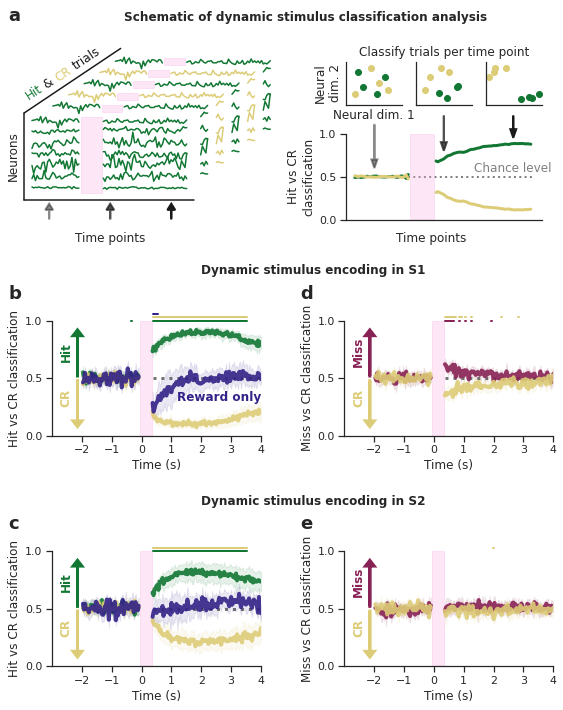

In [59]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(8, 10))

pop.dyn_dec_sketch(session=pas.linear_models[0].session, fig=fig)

gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.07, top=0.55, right=0.97, left=0.1,
                              wspace=0.4, hspace=1)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}

reg_key = 1000
tmp_ps_dict = all_ps_pred_split_tt[reg_key]
tmp_lick_dict = all_lick_pred_split_tt[reg_key]

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot, indicate_spont=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              time_array=time_array_plot)

for reg in ['s1' ,'s2']:
#     if reg == 's1':
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})    
#     hit_ax_dict[reg].set_title('')
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('b' if reg == 's1' else 'c'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('d' if reg == 's1' else 'e'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
hit_ax_dict['s1'].text(s='a', x=-4.48, y=3.6,
                          fontdict={'weight': 'bold', 'size': 18})
hit_ax_dict['s1'].text(s='Schematic of dynamic stimulus classification analysis', x=5.5, y=3.6,
                          fontdict={'weight': 'bold', 'ha': 'center'})

if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Figure3.pdf',
                bbox_to_inches='tight')

# Rerun test with large time window

In [36]:
tp_dict, time_array_plot_merged, window_size_in_sec = pof.create_large_time_windows_for_decoders(tp_dict=tp_dict,
                                                        min_time=-2.5, max_time=4.5)

dict_tt_train = {'hit/cr': ['hit', 'cr'],
                'miss/cr': ['miss', 'cr']}

ps_pred_split_merged, lick_pred_split_merged = {}, {}


In [39]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

for key, list_tt_train in dict_tt_train.items():
    print(f'Now training {key} decoder')

    (_1, _2, lick_pred_split_merged[key], _3, 
     _4, ps_pred_split_merged[key], _5, _6, 
     _7), tmp_dfs = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                                  time_array=tp_dict['decoders_merged_tp'],
                                                  projected_data=False, 
                                                  reg_type='l2', regularizer=1000, 
                                                  average_fun=pof.class_av_mean_accuracy,
                                                  split_fourway=True,
                                                  list_tt_training=list_tt_train,
                                                  concatenate_sessions_per_mouse=False,
                                                  hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                  return_full_dfs=True,
                                                  include_lick_times=True)
 

0it [00:00, ?it/s]

Now training hit/cr decoder


3it [00:28,  9.44s/it]
0it [00:00, ?it/s]

Now training miss/cr decoder


3it [00:25,  8.47s/it]


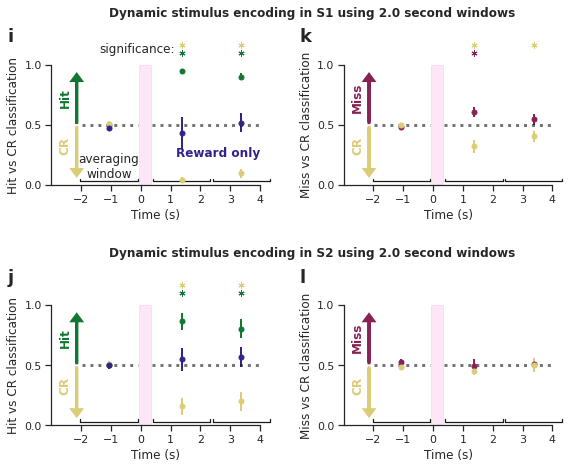

In [41]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(8, 6.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.1, top=0.87, right=0.97, left=0.1,
                              wspace=0.4, hspace=1)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_merged, lick_pred_split=lick_pred_split_merged,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot_merged, indicate_spont=True,
                                              plot_significance=True, 
                                              plot_indiv_data_points_error_bars=True,
                                              time_array_chance=time_array_plot_original,
                                              plot_significance_individually=True,  bottom_sign_bar=1.1)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_merged, lick_pred_split=lick_pred_split_merged,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              time_array=time_array_plot_merged,
                                              plot_significance=True,
                                              plot_indiv_data_points_error_bars=True,
                                              time_array_chance=time_array_plot_original,
                                              plot_significance_individually=True, bottom_sign_bar=1.1)


half_ws = (window_size_in_sec / 2) * 0.96
y_wind = 0.03
y_end = 0.05

# ax_wind = hit_ax_dict['s1']
for ax_wind in [hit_ax_dict['s1'], hit_ax_dict['s2'], miss_ax_dict['s1'], miss_ax_dict['s2']]:
    for i_tp, mid_tp in enumerate(time_array_plot_merged):
        ax_wind.plot([mid_tp - half_ws, mid_tp + half_ws], [y_wind, y_wind], linewidth=1.25, c='k', clip_on=False)
        ax_wind.plot([mid_tp - half_ws, mid_tp - half_ws], [y_end, y_wind], linewidth=1.25, c='k', clip_on=False)
        ax_wind.plot([mid_tp + half_ws, mid_tp + half_ws], [y_end, y_wind], linewidth=1.25, c='k', clip_on=False)
hit_ax_dict['s1'].text(s='averaging\nwindow', x=time_array_plot_merged[0], y=0.04, ha='center', va='bottom')
hit_ax_dict['s1'].text(s='significance:', x=1.15, y=1.08, ha='right', va='bottom')


for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()} using {np.round(window_size_in_sec, 2)} second windows', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('i' if reg == 's1' else 'j'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('k' if reg == 's1' else 'l'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/supp_fig_2sec_window_decoders.pdf',
                bbox_to_inches='tight')

## Decoder accuracy vs response time

In [32]:
tp_dict, time_array_plot_resp_time, window_size_in_sec_resp_time = pof.create_large_time_windows_for_decoders(tp_dict=tp_dict,
                                                        min_time=0, max_time=None, n_window=1)

dict_tt_train = {'hit/cr': ['hit', 'cr']}

ps_pred_split_resp_time, lick_acc_split_resp_time = {}, {}

## Compute results decoders (note: CV of regularisation is down below in the notebook)

for key, list_tt_train in dict_tt_train.items():
    print(f'Now training {key} decoder')

    (_1, _2, lick_acc_split_resp_time[key], _3, _4, 
    ps_pred_split_resp_time[key], _5, _6, 
    _7), tmp_dfs_resp_time = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                                  time_array=tp_dict['decoders_merged_tp'],
                                                  projected_data=False, 
                                                  reg_type='l2', regularizer=1000, 
                                                  average_fun=pof.class_av_mean_accuracy,
                                                  split_fourway=True,
                                                  list_tt_training=list_tt_train,
                                                  concatenate_sessions_per_mouse=False,
                                                  hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                  return_full_dfs=True,
                                                  include_lick_times=True)
 

In [33]:
tp_dict['decoders_merged_tp']

[array([0.36666667])]

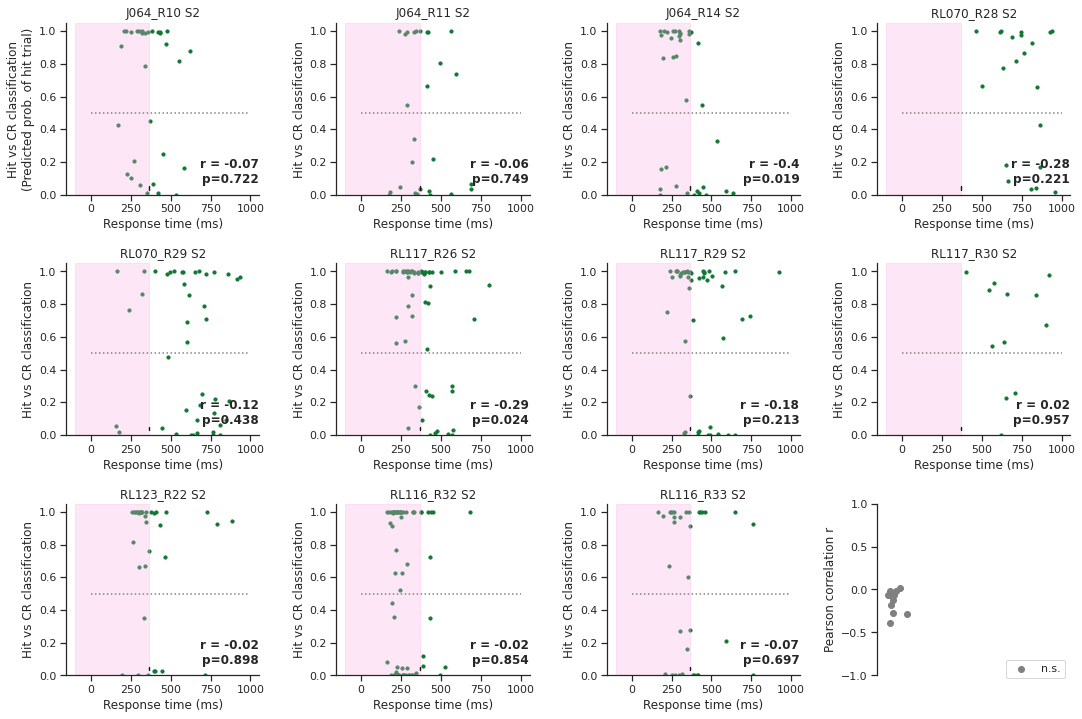

In [34]:
i_time_window = 0 
reg = 's2'

use_df = tmp_dfs_resp_time[i_time_window][reg]['test']
time_array_this_window = tp_dict['decoders_merged_tp'][i_time_window] * 1000  # in ms

pop.plot_correlation_response_time_decoding_accuracy(df_decoder_results=use_df, 
                                        time_array_this_window=time_array_this_window,
                                        tt_show='hit', reg=reg, show_av_window=True,
                                        ax=None, show_all_sessions=True, example_ss='J064_R10', # sessions[0].signature
                                        time_array_plot_original=time_array_plot_original, show_ps=True, 
                                        bonf_corr=True)

# Angles between decoders

In [7]:
## Will start with simple

tp_dict, time_array_plot_merged, window_size_in_sec = pof.create_large_time_windows_for_decoders(tp_dict=tp_dict,
                                                        min_time=-2.5, max_time=4.5)

dict_tt_train = {'hit/cr': ['hit', 'cr'],
                'spont/cr': ['spont', 'cr'],
                 #'hit/miss': ['hit', 'miss'],
                 'miss/cr': ['miss', 'cr']}
                #  'hit/cr 10 trials': ['hit', 'cr']}  # to run 10 trials; set hard_set_10_trials to True

ps_pred_split_angle, lick_pred_split_angle, decoder_weights_angle = {}, {}, {}

## Compute results decoders (note: CV of regularisation is down below in the notebook)

# (lick_acc[key], lick_acc_split[key], lick_pred_split[key], ps_acc[key], 
#      ps_acc_split[key], ps_pred_split[key], lick_half[key], angle_dec[key], 
#      decoder_weights[key])

for key, list_tt_train in dict_tt_train.items():
    print(f'Now training {key} decoder')

    (_1, _2, lick_pred_split_angle[key], _3, 
     _4, ps_pred_split_angle[key], _5, _6, 
     decoder_weights_angle[key]), tmp_dfs = pof.compute_accuracy_time_array_average_per_mouse(sessions=sessions, 
                                                #   time_array=tp_dict['decoders_merged_tp'],
                                                  time_array=tp_dict['decoders'],
                                                  projected_data=False, 
                                                  reg_type='l2', regularizer=1000, 
                                                  average_fun=pof.class_av_mean_accuracy,
                                                  split_fourway=True,
                                                  list_tt_training=list_tt_train,
                                                  concatenate_sessions_per_mouse=False,
                                                  hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                  return_full_dfs=True,
                                                  include_lick_times=True)
 

0it [00:00, ?it/s]

Now training hit/cr decoder


180it [23:52,  7.96s/it]
0it [00:00, ?it/s]

Now training spont/cr decoder


180it [21:24,  7.14s/it]
0it [00:00, ?it/s]

Now training miss/cr decoder


180it [21:21,  7.12s/it]


In [9]:
# ## Compute results decoders (note: CV of regularisation is down below in the notebook)

store_folder = '/home/tplas/repos/popping-off/notebooks/regularisation_optimisation_dyn_dec'

# dt = datetime.now()
# timestamp = str(dt.date()) + '-' + str(dt.hour).zfill(2) + str(dt.minute).zfill(2)

# with open(os.path.join(store_folder, timestamp + '__lick_pred_split_angle.pickle'), 'wb') as handle:
#     pickle.dump(lick_pred_split_angle, handle)

# with open(os.path.join(store_folder, timestamp + '__ps_pred_split_angle.pickle'), 'wb') as handle:
#     pickle.dump(ps_pred_split_angle, handle)

# with open(os.path.join(store_folder, timestamp + '__decoder_weights_angle.pickle'), 'wb') as handle:
#     pickle.dump(decoder_weights_angle, handle)


## To load:

timestamp = '2022-09-12-1028'    
    
with open(os.path.join(store_folder, timestamp + '__lick_pred_split_angle.pickle'), 'rb') as handle:
    lick_pred_split_angle = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__ps_pred_split_angle.pickle'), 'rb') as handle:
    ps_pred_split_angle = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__decoder_weights_angle.pickle'), 'rb') as handle:
    decoder_weights_angle = pickle.load(handle)
    


In [8]:
## 13.5 - 15 GB

print(decoder_weights_angle.keys())
print(decoder_weights_angle['hit/cr']['s1_stim']['J064_R10'].shape)
print(sessions[0], sessions[0].s1_bool.sum())

dict_keys(['hit/cr', 'spont/cr', 'miss/cr'])
(319, 180)
Mouse J064, run 10 319


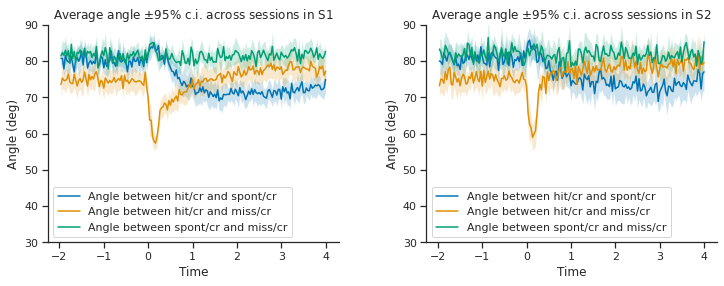

In [10]:
fig, ax_angle = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

dec_combi_list = [['hit/cr', 'spont/cr'], ['hit/cr', 'miss/cr'], ['spont/cr', 'miss/cr']]

for i_reg, reg in enumerate(['s1', 's2']):
    
    for i_combi, combi in enumerate(dec_combi_list):
        dec_1 = combi[0]
        dec_2 = combi[1]
        pop.plot_angle_between_decoders(decoder_weights_angle=decoder_weights_angle,
                                        tp_dict=tp_dict, reg=reg, 
                                        show_heatmap=False, ax_angle_trace=ax_angle[i_reg],
                                        dec_1=dec_1, dec_2=dec_2)
    ax_angle[i_reg].set_ylim([30, 90])
    pop.despine(ax_angle[i_reg])

/home/tplas/repos/popping-off/popoff/popoff/pop_off_functions.py:120: RuntimeWarning: invalid value encountered in arccos
  rad = np.arccos(tmp)


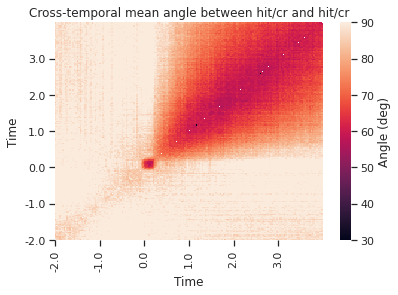

In [11]:
pop.plot_dynamic_angle_between_decoders(decoder_weights_angle=decoder_weights_angle, tp_dict=tp_dict,
                                        reg='s2', dec_1='hit/cr', dec_2='hit/cr')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


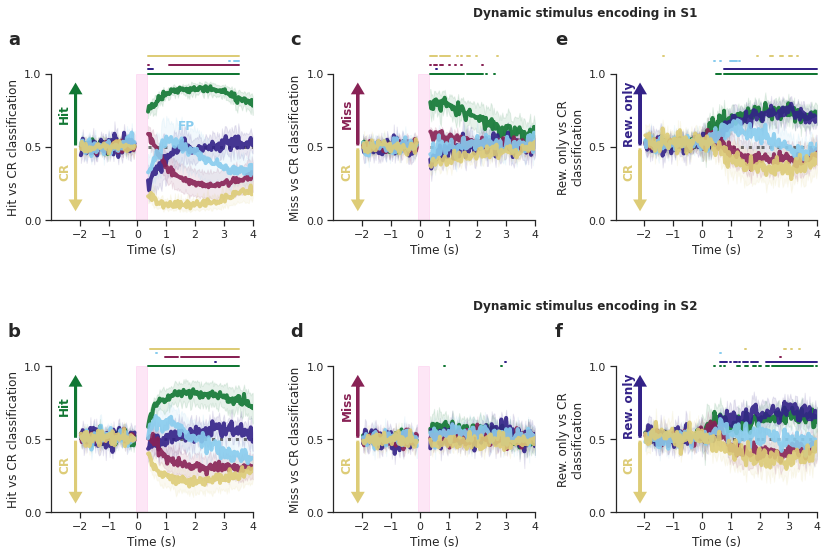

In [8]:
fig = plt.figure(constrained_layout=False, figsize=(16, 7))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.05, top=0.92, right=0.96, left=0.05,
                              wspace=0.4, hspace=1)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}
# hit10_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 3]), 's2': fig.add_subplot(gs_dyn_dec[1, 3])}

# reg_key = 1000
# tmp_ps_dict = all_ps_pred_split_tt[reg_key]
# tmp_lick_dict = all_lick_pred_split_tt[reg_key]
# # tmp_ps_dict = ps_pred_split#[reg_key]
# # tmp_lick_dict = lick_pred_split#[reg_key]


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_angle, lick_pred_split=lick_pred_split_angle,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_angle, lick_pred_split=lick_pred_split_angle,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_angle, lick_pred_split=lick_pred_split_angle,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_full, plot_legend=False, 
                                              plot_artefact=False)

# pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
#                                               decoder_key='hit/cr 10 trials', ax_acc_ps=hit10_ax_dict, 
#                                               time_array=time_array_plot, plot_legend=False)

for reg in ['s1', 's2']:
    miss_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})  
    hit_ax_dict[reg].set_title('')
    spont_ax_dict[reg].set_title('')
    # hit10_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('a' if reg == 's1' else 'b'), x=-4.5, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('c' if reg == 's1' else 'd'), x=-4.5, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    spont_ax_dict[reg].text(s=('e' if reg == 's1' else 'f'), x=-5.1, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    # hit10_ax_dict[reg].text(s=('g' if reg == 's1' else 'h'), x=-5.1, y=1.2,
    #                       fontdict={'weight': 'bold', 'size': 18})
 


# Additional stat tests:
(Of claims in manuscript)

In [ ]:
## Spont vs CR in S2 is not significant until:

tmp = pof.stat_test_dyn_dec(pred_dict=tmp_ps_dict, decoder_name='hit/cr', tt='spont', region='s2',
                      time_array=time_array_plot, frames_bin=2, th=0.05)

time_array_plot[tmp[1].astype('bool')]

In [ ]:
## Hit and Spont are identical on Spont/CR decoder, both S1 and S2

reg = 's2'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=tmp_lick_dict, decoder_name_1='spont/cr', tt_1='hit', region_1=reg,
                                 pred_dict_2=tmp_lick_dict, decoder_name_2='spont/cr', tt_2='spont', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

In [ ]:
## Miss vs CR in S1 is significant until:

tmp = pof.stat_test_dyn_dec(pred_dict=tmp_ps_dict, decoder_name='miss/cr', tt='miss', region='s1',
                      time_array=time_array_plot, frames_bin=2, th=0.05)

time_array_plot[tmp[1].astype('bool')]

In [ ]:
## Hit preidctions greater than spont on Hit/cr 10 trials classifier

reg = 's2'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=tmp_ps_dict, decoder_name_1='hit/cr 10 trials', tt_1='hit', region_1=reg,
                                 pred_dict_2=tmp_lick_dict, decoder_name_2='hit/cr 10 trials', tt_2='spont', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

print(f'Number of significantly different time points: {int(np.sum(tmp[2][70:]))}/{len(tmp[2][70:])}')

In [ ]:
## Hit predictions greater with miss/cr than Hit/cr 
tmp_ps_dict_flip_miss = copy.deepcopy(tmp_ps_dict)

for ses_reg_name, data in tmp_ps_dict_flip_miss['miss/cr']['miss'].items():
    data[:, 0] = 1 - data[:, 0]

reg = 's1'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=tmp_ps_dict, decoder_name_1='miss/cr', tt_1='cr', region_1=reg,
                                 pred_dict_2=tmp_ps_dict_flip_miss, decoder_name_2='miss/cr', tt_2='miss', region_2=reg,
                                 time_array=time_array_plot, frames_bin=2, th=0.05, 
                                 alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

print(f'Number of significantly different time points: {int(np.sum(tmp[2][70:]))}/{len(tmp[2][70:])}')

In [ ]:
## Hit 40/50 stim vs hit 5/10 stim in S1
tmp_ps_dict = all_ps_pred_split_tt_nstim[reg_key]
print(reg_key)
reg = 's2'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=tmp_ps_dict, decoder_name_1='hit/cr', tt_1='miss_n3', region_1=reg,
                                     pred_dict_2=tmp_ps_dict, decoder_name_2='hit/cr', tt_2='miss_n1', region_2=reg,
                                     time_array=time_array_plot, frames_bin=2, th=0.05, 
                                     alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

print(f'Number of significantly different time points: {int(np.sum(tmp[2][70:]))}/{len(tmp[2][70:])}')
time_array_plot[tmp[2].astype('bool')]

In [ ]:
## Hit 40/50 stim vs hit 5/10 stim in S1
tmp_ps_dict = all_ps_pred_split_tt_covar[reg_key]
print(reg_key)
reg = 's1'
tmp = pof.stat_test_dyn_dec_two_arrays(pred_dict_1=tmp_ps_dict, decoder_name_1='hit/cr', tt_1='miss_c3', region_1=reg,
                                     pred_dict_2=tmp_ps_dict, decoder_name_2='hit/cr', tt_2='miss_c1', region_2=reg,
                                     time_array=time_array_plot, frames_bin=2, th=0.05, covar_name='variance_cell_rates_s1',
                                     alternative='two-sided')

plt.plot(time_array_plot, tmp[2])

print(f'Number of significantly different time points: {int(np.sum(tmp[2][70:]))}/{len(tmp[2][70:])}')
time_array_plot[tmp[2].astype('bool')]

In [ ]:
tmp_ps_dict['hit/cr']['variance_cell_rates_s1'].keys()

# Supp 1 (all trial types)

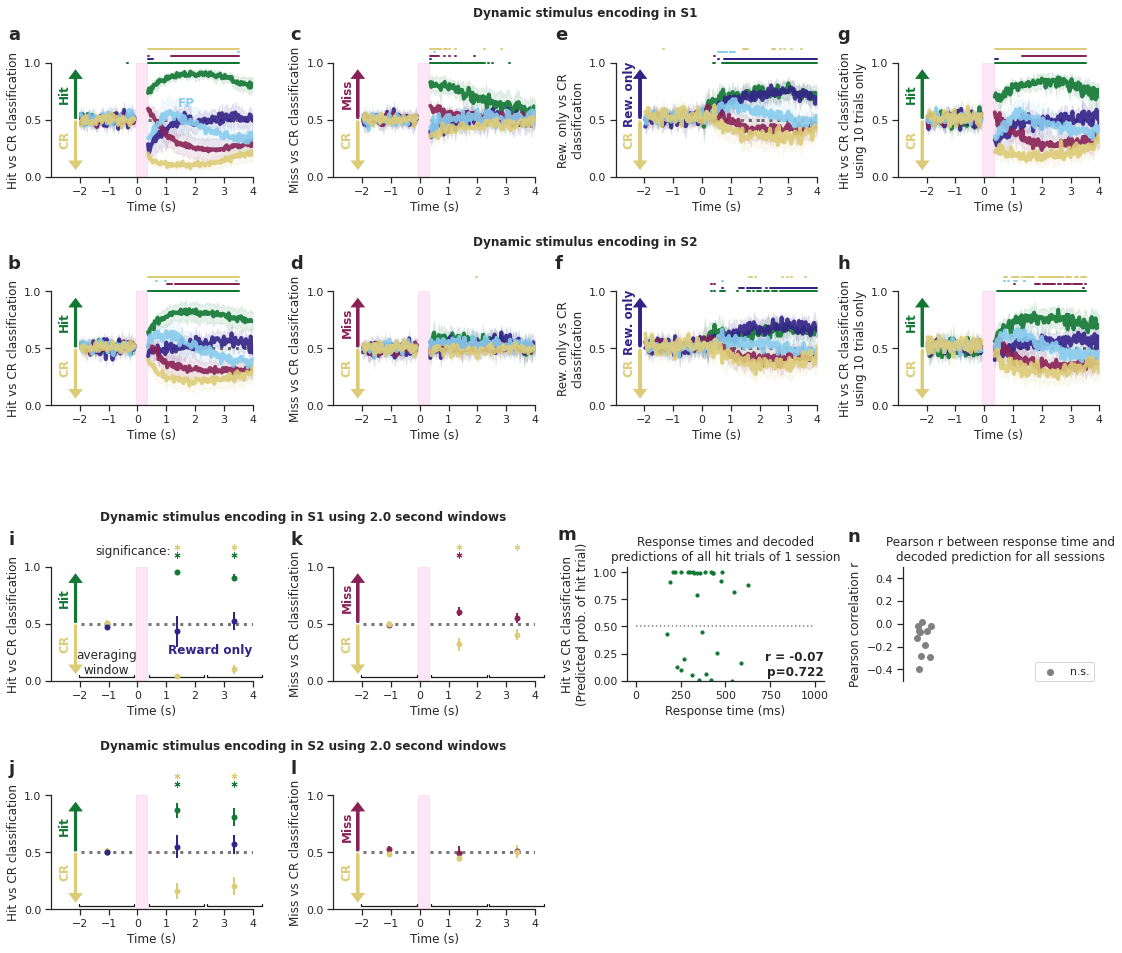

In [43]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(16, 14))
gs_dyn_dec = fig.add_gridspec(ncols=4, nrows=2, bottom=0.58, top=0.92, right=0.96, left=0.05,
                              wspace=0.4, hspace=1)

hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
spont_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}
hit10_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 3]), 's2': fig.add_subplot(gs_dyn_dec[1, 3])}

reg_key = 1000
tmp_ps_dict = all_ps_pred_split_tt[reg_key]
tmp_lick_dict = all_lick_pred_split_tt[reg_key]
# tmp_ps_dict = ps_pred_split#[reg_key]
# tmp_lick_dict = lick_pred_split#[reg_key]


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False,
                                              indicate_fp=True)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='spont/cr', ax_acc_ps=spont_ax_dict, 
                                              time_array=time_array_full, plot_legend=False, 
                                              plot_artefact=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr 10 trials', ax_acc_ps=hit10_ax_dict, 
                                              time_array=time_array_plot, plot_legend=False)

for reg in ['s1', 's2']:
    miss_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})  
    hit_ax_dict[reg].set_title('')
    spont_ax_dict[reg].set_title('')
    hit10_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('a' if reg == 's1' else 'b'), x=-4.5, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('c' if reg == 's1' else 'd'), x=-4.5, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    spont_ax_dict[reg].text(s=('e' if reg == 's1' else 'f'), x=-5.1, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
    hit10_ax_dict[reg].text(s=('g' if reg == 's1' else 'h'), x=-5.1, y=1.2,
                          fontdict={'weight': 'bold', 'size': 18})
 

####### 
## Large window decoders 

gs_large_window = fig.add_gridspec(ncols=2, nrows=2, bottom=0.08, top=0.42, right=0.47, left=0.05,
                              wspace=0.4, hspace=1)

hit_ax_dict = {'s1': fig.add_subplot(gs_large_window[0, 0]), 's2': fig.add_subplot(gs_large_window[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_large_window[0, 1]), 's2': fig.add_subplot(gs_large_window[1, 1])}


pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_merged, lick_pred_split=lick_pred_split_merged,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot_merged, indicate_spont=True,
                                              plot_significance=True, 
                                              plot_indiv_data_points_error_bars=True,
                                              time_array_chance=time_array_plot_original,
                                              plot_significance_individually=True,  bottom_sign_bar=1.1)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=ps_pred_split_merged, lick_pred_split=lick_pred_split_merged,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              time_array=time_array_plot_merged,
                                              plot_significance=True,
                                              plot_indiv_data_points_error_bars=True,
                                              time_array_chance=time_array_plot_original,
                                              plot_significance_individually=True, bottom_sign_bar=1.1)


half_ws = (window_size_in_sec / 2) * 0.96
y_wind = 0.03
y_end = 0.05

for ax_wind in [hit_ax_dict['s1'], hit_ax_dict['s2'], miss_ax_dict['s1'], miss_ax_dict['s2']]:
    for i_tp, mid_tp in enumerate(time_array_plot_merged):
        ax_wind.plot([mid_tp - half_ws, mid_tp + half_ws], [y_wind, y_wind], linewidth=1.25, c='k', clip_on=False)
        ax_wind.plot([mid_tp - half_ws, mid_tp - half_ws], [y_end, y_wind], linewidth=1.25, c='k', clip_on=False)
        ax_wind.plot([mid_tp + half_ws, mid_tp + half_ws], [y_end, y_wind], linewidth=1.25, c='k', clip_on=False)
hit_ax_dict['s1'].text(s='averaging\nwindow', x=time_array_plot_merged[0], y=0.04, ha='center', va='bottom')
hit_ax_dict['s1'].text(s='significance:', x=1.15, y=1.08, ha='right', va='bottom')

for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()} using {np.round(window_size_in_sec, 2)} second windows', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('i' if reg == 's1' else 'j'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('k' if reg == 's1' else 'l'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
                          
########
### Response time vs decoding accuracy 

gs_resp_time = fig.add_gridspec(ncols=2, nrows=2, bottom=0.08, top=0.42, right=0.96, left=0.55,
                              wspace=0.4, hspace=1)
ax_resp_time =[fig.add_subplot(gs_resp_time[0, 0]), fig.add_subplot(gs_resp_time[0, 1])]            
i_time_window = 0 
reg = 's2'

use_df = tmp_dfs_resp_time[i_time_window][reg]['test']
time_array_this_window = tp_dict['decoders_merged_tp'][i_time_window] * 1000  # in ms

pop.plot_correlation_response_time_decoding_accuracy(df_decoder_results=use_df, 
                                        time_array_this_window=time_array_this_window,
                                        tt_show='hit', reg=reg, show_av_window=False,
                                        ax=ax_resp_time, show_all_sessions=False, example_ss='J064_R10', # sessions[0].signature
                                        time_array_plot_original=time_array_plot_original, show_ps=False, 
                                        bonf_corr=True)
ax_resp_time[0].set_title('Response times and decoded\npredictions of all hit trials of 1 session')
ax_resp_time[1].set_title('Pearson r between response time and\ndecoded prediction for all sessions')
ax_resp_time[0].text(s='m', x=-440, y=1.3, fontdict={'weight': 'bold', 'size': 18})
# ax_resp_time[1].text(s='n', x=-3.5, y=1.42, fontdict={'weight': 'bold', 'size': 18})  # if ylim goes up to 1
ax_resp_time[1].text(s='n', x=-3.5, y=0.72, fontdict={'weight': 'bold', 'size': 18})
ax_resp_time[1].set_ylim([-0.5, 0.5])
if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure4.pdf')#,
#                 bbox_to_inches='tight')
    

# Supp 2 (indiv animals)

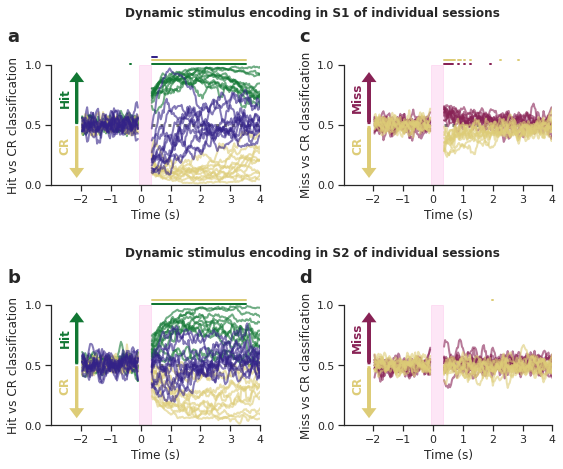

In [76]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(8, 6.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.1, top=0.87, right=0.97, left=0.1,
                              wspace=0.4, hspace=1)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}

reg_key = 1000
tmp_ps_dict = all_ps_pred_split_tt[reg_key]
tmp_lick_dict = all_lick_pred_split_tt[reg_key]

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                              plot_indiv=True, smooth_traces=True,
                                              plot_tt=['hit', 'cr', 'spont'], plot_legend=False,
                                              time_array=time_array_plot, indicate_spont=False,
                                              plot_mean=False,
                                              bottom_sign_bar=1.01, plot_ci=False)

pop.plot_dynamic_decoding_two_regions_wrapper(ps_pred_split=tmp_ps_dict, lick_pred_split=tmp_lick_dict,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                              plot_indiv=True, smooth_traces=True,
                                              plot_tt=['miss', 'cr'], plot_legend=False,
                                              plot_ci=False, plot_mean=False,
                                              time_array=time_array_plot, bottom_sign_bar=1.01)

for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()} of individual sessions', 
                               x=1.25, y=1.35, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('a' if reg == 's1' else 'b'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('c' if reg == 's1' else 'd'), x=-4.48, y=1.19,
                          fontdict={'weight': 'bold', 'size': 18})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure5.pdf',
                bbox_to_inches='tight')

In [ ]:
for ses_reg_name, data in tmp_ps_dict['miss/cr']['cr'].items():
    if ses_reg_name[-2:] == 's1' and ses_reg_name[:4] == 'J064':
        trace = copy.deepcopy(data[:, 0][72:])
        plt.plot(trace, label=ses_reg_name)
plt.legend(bbox_to_anchor=(1, 1))

## Supp figs; split by n_stim or pop var:

skipping RL117_R30_s1
skipping J064_R10_s1
skipping RL117_R30_s2
skipping J064_R10_s2
skipping RL117_R30_s1
skipping J064_R10_s1
skipping RL117_R30_s2
skipping J064_R10_s2


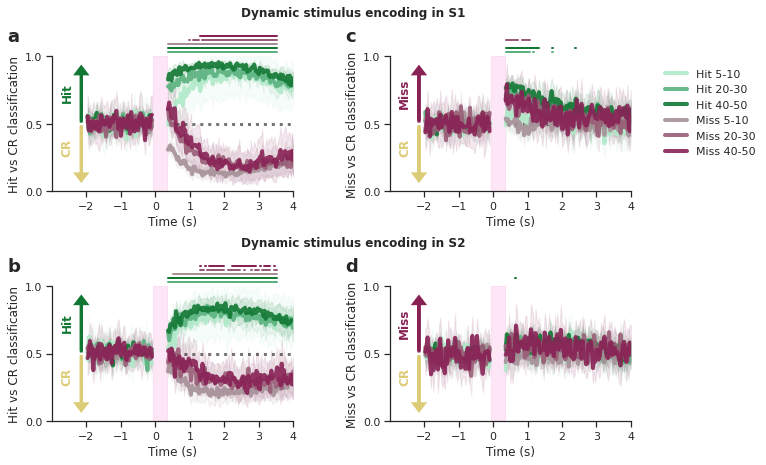

In [78]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(12, 6.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.1, top=0.88, right=0.75, left=0.08,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
# hitmiss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}

reg_key = 1000
tmp_ps_dict = all_ps_pred_split_tt_nstim[reg_key]
tmp_lick_dict = all_lick_pred_split_tt_nstim[reg_key]


pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
                                                    lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                                    plot_legend=False, name_cov=None,
                                                    plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
                                                       'miss_n1', 'miss_n2', 'miss_n3'],
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
                                                    lick_pred_split=tmp_lick_dict,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                                    plot_legend=True,name_cov=None,
                                                    plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
                                                       'miss_n1', 'miss_n2', 'miss_n3'],
                                              time_array=time_array_plot)

# pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
#                                                     lick_pred_split=tmp_lick_dict,
#                                               decoder_key='hit/miss', ax_acc_ps=hitmiss_ax_dict, 
#                                                     plot_legend=True,name_cov=None,
#                                                     plot_tt=['hit_n1', 'hit_n2', 'hit_n3', 
#                                                        'miss_n1', 'miss_n2', 'miss_n3'],
#                                               time_array=time_array_plot)


for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.25, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('a' if reg == 's1' else 'b'), x=-4.3, y=1.11,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('c' if reg == 's1' else 'd'), x=-4.3, y=1.11,
                          fontdict={'weight': 'bold', 'size': 18})
#     hitmiss_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
    
#     pop.naked(miss_ax_dict[reg])
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure8.pdf',
                bbox_to_inches='tight')

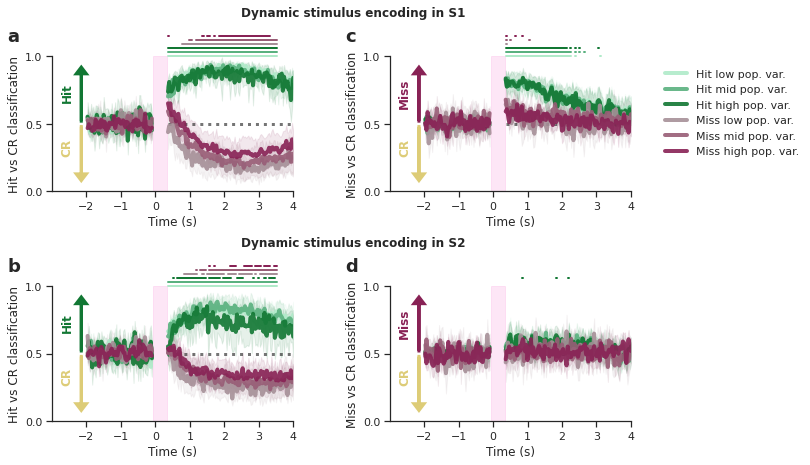

In [80]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=(12, 6.5))
gs_dyn_dec = fig.add_gridspec(ncols=2, nrows=2, bottom=0.1, top=0.88, right=0.75, left=0.08,
                              wspace=0.4, hspace=0.7)
hit_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 0]), 's2': fig.add_subplot(gs_dyn_dec[1, 0])}
miss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 1]), 's2': fig.add_subplot(gs_dyn_dec[1, 1])}
# hitmiss_ax_dict = {'s1': fig.add_subplot(gs_dyn_dec[0, 2]), 's2': fig.add_subplot(gs_dyn_dec[1, 2])}

reg_key = 1000
tmp_ps_dict = all_ps_pred_split_tt_covar[reg_key]
tmp_lick_dict = all_lick_pred_split_tt_covar[reg_key]


pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
                                                    lick_pred_split=tmp_lick_dict,
                                              decoder_key='hit/cr', ax_acc_ps=hit_ax_dict, 
                                                    plot_legend=False,
                                              time_array=time_array_plot)

pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
                                                    lick_pred_split=tmp_lick_dict,
                                              decoder_key='miss/cr', ax_acc_ps=miss_ax_dict, 
                                                    plot_legend=True,
                                              time_array=time_array_plot)

# pop.plot_dynamic_decoding_two_regions_wrapper_split(ps_pred_split=tmp_ps_dict, 
#                                                     lick_pred_split=tmp_lick_dict,
#                                               decoder_key='hit/miss', ax_acc_ps=hitmiss_ax_dict, 
#                                                     plot_legend=True,
#                                               time_array=time_array_plot)


for reg in ['s1' ,'s2']:
    hit_ax_dict[reg].set_title(f'Dynamic stimulus encoding in {reg.upper()}', 
                               x=1.25, y=1.25, fontdict={'weight': 'bold'})    
    miss_ax_dict[reg].set_title('')
    hit_ax_dict[reg].text(s=('a' if reg == 's1' else 'b'), x=-4.3, y=1.11,
                          fontdict={'weight': 'bold', 'size': 18})
    miss_ax_dict[reg].text(s=('c' if reg == 's1' else 'd'), x=-4.3, y=1.11,
                          fontdict={'weight': 'bold', 'size': 18})
#     hitmiss_ax_dict[reg].text(s=('E' if reg == 's1' else 'F'), x=-4.5, y=1.19,
#                           fontdict={'weight': 'bold'})
    
if save_fig:        
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure9.pdf',
                bbox_to_inches='tight')

# Optimize regularisation strength

In [57]:
tp_dict['decoders'] = tp_dict['mutual']
tp_dict['decoders'] = tp_dict['decoders'][np.logical_and(tp_dict['decoders'] >- 2, 
                                                         tp_dict['decoders'] <= 4)]
tp_dict['decoders'] = tp_dict['decoders']#[::60]

pre_stim_art_time = -0.07
post_stim_art_time = 0.35
time_array_plot = copy.deepcopy(tp_dict['decoders'])
time_array_full = copy.deepcopy(tp_dict['decoders'])
time_array_plot[np.logical_and(time_array_plot >= pre_stim_art_time, 
                               time_array_plot < post_stim_art_time)] = np.nan
time_array_full -= pre_stim_art_time
time_array_plot -= pre_stim_art_time


dict_tt_train = {#'hit/cr': ['hit', 'cr'],
                #  'hit/miss': ['hit', 'miss'],
                #  'miss/cr': ['miss', 'cr'],
                #  'spont/cr': ['spont', 'cr'],
                 'hit/cr 10 trials': ['hit', 'cr']}  # to run 10 trials; set hard_set_10_trials to True

# all_lick_pred_split_tt, all_lick_pred_split_tt_nstim, all_lick_pred_split_tt_covar = {}, {} ,{}
# all_ps_pred_split_tt, all_ps_pred_split_tt_nstim, all_ps_pred_split_tt_covar = {}, {}, {}


In [58]:
reg_strength_array = np.logspace(-3, 7, 11)
print('Regularisation strength: ', reg_strength_array)

Regularisation strength:  [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06
 1.e+07]


In [59]:
## Compute results decoders (note: CV of regularisation is down below in the notebook)

store_folder = '/home/tplas/repos/popping-off/notebooks/regularisation_optimisation_dyn_dec'

for i_reg, reg_strength in enumerate(reg_strength_array):
    # (all_lick_pred_split_tt[reg_strength], all_lick_pred_split_tt_nstim[reg_strength], 
    #  all_lick_pred_split_tt_covar[reg_strength], all_ps_pred_split_tt[reg_strength], 
    #  all_ps_pred_split_tt_nstim[reg_strength], 
    #  all_ps_pred_split_tt_covar[reg_strength]) = {}, {}, {}, {}, {}, {}
    for key, list_tt_train in dict_tt_train.items():
        print(f'Now training {key} decoder of regularisation iteration {i_reg + 1}/{len(reg_strength_array)}')

        (all_lick_pred_split_tt[reg_strength][key], all_lick_pred_split_tt_nstim[reg_strength][key], 
         all_lick_pred_split_tt_covar[reg_strength][key], all_ps_pred_split_tt[reg_strength][key], 
         all_ps_pred_split_tt_nstim[reg_strength][key], 
         all_ps_pred_split_tt_covar[reg_strength][key]) = pof.compute_prediction_time_array_average_per_mouse_split(sessions=sessions, 
                                                      time_array=tp_dict['decoders'],
                                                      projected_data=False, 
                                                      reg_type='l2', regularizer=reg_strength, 
                                                      average_fun=pof.class_av_mean_accuracy,
                                                      list_tt_training=list_tt_train,
                                                      concatenate_sessions_per_mouse=False,
                                                      hard_set_10_trials=(True if key == 'hit/cr 10 trials' else False),
                                                      list_save_covs=['variance_cell_rates_s1'])
dt = datetime.now()
timestamp = str(dt.date()) + '-' + str(dt.hour).zfill(2) + str(dt.minute).zfill(2)
with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt, handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_nstim.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt_nstim, handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_covar.pickle'), 'wb') as handle:
    pickle.dump(all_lick_pred_split_tt_covar, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_nstim.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt_nstim, handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_covar.pickle'), 'wb') as handle:
    pickle.dump(all_ps_pred_split_tt_covar, handle)
    
    
    


0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 1/11


180it [27:39,  9.22s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 2/11


180it [27:27,  9.15s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 3/11


180it [27:28,  9.16s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 4/11


180it [27:37,  9.21s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 5/11


180it [28:02,  9.35s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 6/11


180it [28:13,  9.41s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 7/11


180it [28:01,  9.34s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 8/11


180it [27:53,  9.30s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 9/11


180it [28:08,  9.38s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 10/11


180it [28:05,  9.36s/it]
0it [00:00, ?it/s]

Now training hit/cr 10 trials decoder of regularisation iteration 11/11


180it [28:04,  9.36s/it]


In [22]:
# To load:
store_folder = '/home/tplas/repos/popping-off/notebooks/regularisation_optimisation_dyn_dec/'
# timestamp = '2021-10-28-1457'
timestamp = '2022-09-05-2228'
# with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt.pickle'), 'rb') as handle:
#     tmp = pickle.load(handle)
    
    
with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt.pickle'), 'rb') as handle:
    all_lick_pred_split_tt = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_nstim.pickle'), 'rb') as handle:
    all_lick_pred_split_tt_nstim = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__all_lick_pred_split_tt_covar.pickle'), 'rb') as handle:
    all_lick_pred_split_tt_covar = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt.pickle'), 'rb') as handle:
    all_ps_pred_split_tt = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_nstim.pickle'), 'rb') as handle:
    all_ps_pred_split_tt_nstim = pickle.load(handle)

with open(os.path.join(store_folder, timestamp + '__all_ps_pred_split_tt_covar.pickle'), 'rb') as handle:
    all_ps_pred_split_tt_covar = pickle.load(handle)
    

In [20]:
# all_ps_pred_split_tt[100.0]['hit/cr']['hit']['J064_R10_s1'].shape
all_ps_pred_split_tt.keys()

dict_keys([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0])

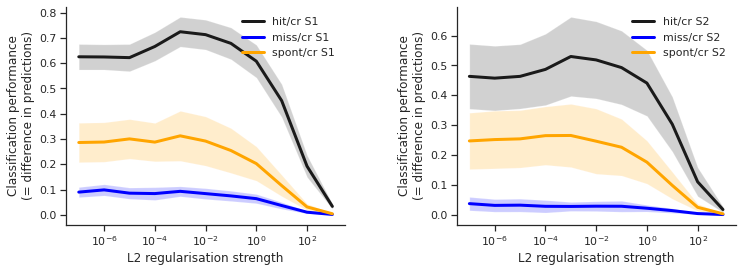

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})
save_fig = False

for i_reg, reg in enumerate(['s1', 's2']):
    pop.plot_regularisation_optimisation(all_data_dict=all_ps_pred_split_tt, time_array_plot=time_array_plot,
                                        decoder_key='hit/cr', tt_pos='hit', tt_neg='cr', reg=reg, ax=ax[i_reg])
    pop.plot_regularisation_optimisation(all_data_dict=all_ps_pred_split_tt, time_array_plot=time_array_plot,
                                        decoder_key='miss/cr', tt_pos='miss', tt_neg='cr', c='blue', reg=reg, ax=ax[i_reg])
    pop.plot_regularisation_optimisation(all_data_dict=all_lick_pred_split_tt, time_array_plot=time_array_plot,
                                        decoder_key='spont/cr', tt_pos='spont', tt_neg='cr', c='orange', reg=reg, ax=ax[i_reg])
    
if save_fig:
    
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/fig3_supp_regularisation_optimisation.pdf',
                bbox_to_inches='tight')

In [ ]:
all_ps_pred_split_tt